# Notebook for the making of Figure 6 and Table 1 - Accuracy vs Intensity

In [1]:
import numpy as np
import pylab as plt
from numpy.fft import fftshift, ifftshift
import tensorflow as tf 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from predict_phase_2D_utilities import *

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from functions import*
from interpolation_functions import*
from line_cross_standard_utilities import *
from line_cross_tensorflow_prediction_utilities import *

plt.rcParams['image.cmap'] = 'plasma'

2.2.0
Num GPUs Available:  1


2023-12-13 15:06:59.897401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-12-13 15:06:59.998461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0035:03:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.50GiB deviceMemoryBandwidth: 836.37GiB/s
2023-12-13 15:07:00.003841: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-12-13 15:07:00.013356: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-12-13 15:07:00.018462: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-12-13 15:07:00.022881: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so

In [2]:
path = 'path_to_image4'
data_full = np.load(path)

I = 1e5*data_full['I']

Ilog = np.log(I+1)

nb_samples = 1000
gappos = np.random.randint(17,112, size = (3,nb_samples)) # create a matrix of random positions for the window

dataset_log = SmartCrop3D_mask(Ilog,32, mode = 'custom', matrix = gappos)
dataset_lin = SmartCrop3D_mask(I,32, mode = 'custom', matrix = gappos)



In [3]:
i= 0
mask3 = add_vertical_gap3D(dataset_log[i], gap_size = 3, gap_position = 16, min_distance_from_center = 10, plot=False)
mask6 = add_vertical_gap3D(dataset_log[i], gap_size = 6, gap_position = 16, min_distance_from_center = 10, plot=False)
mask9 = add_vertical_gap3D(dataset_log[i], gap_size = 9, gap_position = 16, min_distance_from_center = 10, plot=False)
mask12 = add_vertical_gap3D(dataset_log[i], gap_size = 12, gap_position = 16, min_distance_from_center = 10, plot=False)

In [4]:
model3 = keras.models.load_model('path_to_model_3px', compile = False)
model6 = keras.models.load_model('path_to_model_6px', compile = False)
model9 = keras.models.load_model('path_to_model_9px', compile = False)
model12 = keras.models.load_model('path_to_model_12px', compile = False)

2023-12-13 15:07:03.610808: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2300000000 Hz
2023-12-13 15:07:03.611282: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ea97050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-13 15:07:03.611294: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-12-13 15:07:03.748310: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1edf73d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 15:07:03.748336: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-12-13 15:07:03.748784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0035:03:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 d

# Calculate predictions

In [12]:
res3 = np.zeros((nb_samples,32*32*3)) # one column for accuracy, one column for intensities
res6 = np.zeros((nb_samples,32*32*6)) # one column for accuracy, one column for intensities
res9 = np.zeros((nb_samples,32*32*9)) # one column for accuracy, one column for intensities
res12 = np.zeros((nb_samples,32*32*12)) # one column for accuracy, one column for intensities

sum_int3 = np.zeros((nb_samples))
sum_int6 = np.zeros((nb_samples))
sum_int9 = np.zeros((nb_samples))
sum_int12 = np.zeros((nb_samples))
accu3 = np.zeros((nb_samples))
accu6 = np.zeros((nb_samples))
accu9 = np.zeros((nb_samples))
accu12 = np.zeros((nb_samples))



mini = np.zeros((dataset_log.shape[0]))
maxi = np.zeros((dataset_log.shape[0]))

renorm = np.zeros_like(dataset_log)

mask3 = add_vertical_gap3D(dataset_log[0], gap_size = 3, gap_position = 16, min_distance_from_center = 10, plot=False)
mask3 = np.tile(mask3[np.newaxis,...], (dataset_log.shape[0],1,1,1))     

mask6 = add_vertical_gap3D(dataset_log[0], gap_size = 6, gap_position = 16, min_distance_from_center = 10, plot=False)
mask6 = np.tile(mask6[np.newaxis,...], (dataset_log.shape[0],1,1,1))     

mask9 = add_vertical_gap3D(dataset_log[0], gap_size = 9, gap_position = 16, min_distance_from_center = 10, plot=False)
mask9 = np.tile(mask9[np.newaxis,...], (dataset_log.shape[0],1,1,1))     

mask12 = add_vertical_gap3D(dataset_log[0], gap_size = 12, gap_position = 16, min_distance_from_center = 10, plot=False)
mask12 = np.tile(mask12[np.newaxis,...], (dataset_log.shape[0],1,1,1))   

x = np.zeros((nb_samples))
x_lin = np.zeros((nb_samples))

for i in range(nb_samples):
    
    mini[i] = dataset_log[i].min()
    maxi[i] = dataset_log[i].max()
    
    renorm[i] = np.interp(dataset_log[i], (mini[i], maxi[i]), (0,1))
    
    x[i] = 100*(np.sum(renorm[i]))/(32*32*32)  
    x_lin[i] = np.sum(dataset_lin[i])/(32*32*32)
    
inp3 = np.reshape(renorm*(1.-mask3), (dataset_log.shape[0],32,32,32,1))
pred3 = model3.predict(inp3)[...,0]
pred3 = pred3*mask3 + renorm*(1.-mask3)

inp6 = np.reshape(renorm*(1.-mask6), (dataset_log.shape[0],32,32,32,1))
pred6 = model6.predict(inp6)[...,0]
pred6 = pred6*mask6 + renorm*(1.-mask6)

inp9 = np.reshape(renorm*(1.-mask9), (dataset_log.shape[0],32,32,32,1))
pred9 = model9.predict(inp9)[...,0]
pred9 = pred9*mask9 + renorm*(1.-mask9)

inp12 = np.reshape(renorm*(1.-mask12), (dataset_log.shape[0],32,32,32,1))
pred12 = model12.predict(inp12)[...,0]
pred12 = pred12*mask12 + renorm*(1.-mask12)
#________________________________________________________________________________________________________________________

# ** I HAVE ALL THE PREDICTIONS HERE **

pred3lin = np.zeros_like(pred3)
pred6lin = np.zeros_like(pred3)
pred9lin = np.zeros_like(pred3)
pred12lin = np.zeros_like(pred3)

positions3 = np.zeros((nb_samples,32*32*3))
positions6 = np.zeros((nb_samples,32*32*6))
positions9 = np.zeros((nb_samples,32*32*9))
positions12 = np.zeros((nb_samples,32*32*12))

for i in range(nb_samples):
    
    pred3[i] = np.interp(pred3[i],(pred3[i].min(),pred3[i].max()), (mini[i], maxi[i])) # still in log scale
    pred6[i] = np.interp(pred6[i],(pred6[i].min(),pred6[i].max()), (mini[i], maxi[i]))    
    pred9[i] = np.interp(pred9[i],(pred9[i].min(),pred9[i].max()), (mini[i], maxi[i]))    
    pred12[i] = np.interp(pred12[i],(pred12[i].min(),pred12[i].max()), (mini[i], maxi[i]))
    
    pred3lin[i] = np.exp(pred3[i]) - 1    # lin scale
    pred6lin[i] = np.exp(pred6[i]) - 1
    pred9lin[i] = np.exp(pred9[i]) - 1
    pred12lin[i] = np.exp(pred12[i]) - 1
    
    # arrays of accuracies and positions shape = (100, 32*32*gapsize)
    
    res3[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,15:18,:] - pred3lin[i,:,15:18,:])/dataset_lin[i,:,15:18,:])*100)
    res3[i][res3[i] < 0] = 0   

    res6[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,13:19,:] - pred6lin[i,:,13:19,:])/dataset_lin[i,:,13:19,:])*100)
    res6[i][res6[i] < 0] = 0
    
    res9[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,12:21,:] - pred9lin[i,:,12:21,:])/dataset_lin[i,:,12:21,:])*100)
    res9[i][res9[i] < 0] = 0

    res12[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,10:22,:] - pred12lin[i,:,10:22,:])/dataset_lin[i,:,10:22,:])*100)
    res12[i][res12[i] < 0] = 0
    
    accu3[i] = pearson_coef(dataset_log[i,:,15:18,:],pred3[i,:,15:18,:])

    accu6[i] = pearson_coef(dataset_log[i,:,13:19,:],pred6[i,:,13:19,:])

    accu9[i] = pearson_coef(dataset_log[i,:,12:21,:],pred9[i,:,12:21,:])

    accu12[i] = pearson_coef(dataset_log[i,:,10:22,:],pred12[i,:,10:22,:])



/tmp/ipykernel_2872467/2992607072.py:90: RuntimeWarning: divide by zero encountered in true_divide
  res3[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,15:18,:] - pred3lin[i,:,15:18,:])/dataset_lin[i,:,15:18,:])*100)
/tmp/ipykernel_2872467/2992607072.py:93: RuntimeWarning: divide by zero encountered in true_divide
  res6[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,13:19,:] - pred6lin[i,:,13:19,:])/dataset_lin[i,:,13:19,:])*100)
/tmp/ipykernel_2872467/2992607072.py:96: RuntimeWarning: divide by zero encountered in true_divide
  res9[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,12:21,:] - pred9lin[i,:,12:21,:])/dataset_lin[i,:,12:21,:])*100)
/tmp/ipykernel_2872467/2992607072.py:99: RuntimeWarning: divide by zero encountered in true_divide
  res12[i] = np.ndarray.flatten((1 - np.abs(dataset_lin[i,:,10:22,:] - pred12lin[i,:,10:22,:])/dataset_lin[i,:,10:22,:])*100)


In [13]:
xax,avg_acc3 = average_scatter(np.log(x_lin), accu3, 20)
xax,avg_acc6 = average_scatter(np.log(x_lin), accu6, 20)
xax,avg_acc9 = average_scatter(np.log(x_lin), accu9, 20)
xax,avg_acc12 = average_scatter(np.log(x_lin), accu12, 20)

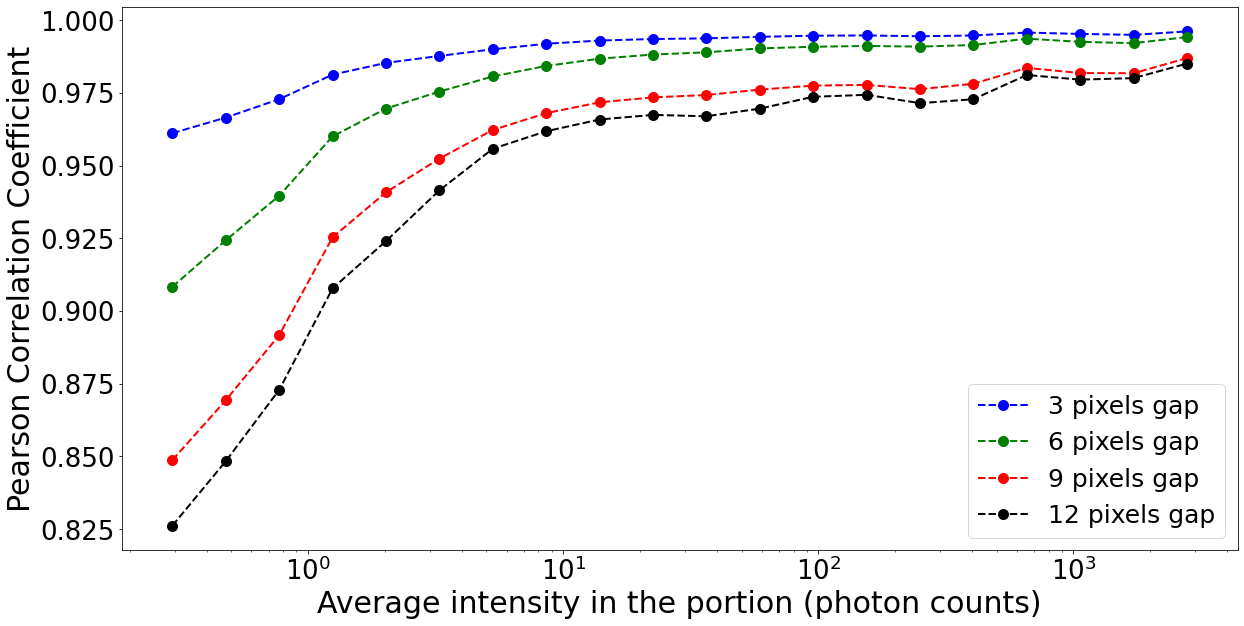

In [14]:
fig = plt.figure(figsize = (20,10))
plt.xlabel('Average intensity in the portion (photon counts)', fontsize = 30)
plt.ylabel('Pearson Correlation Coefficient', fontsize = 30)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.plot(np.exp(xax), avg_acc3, color = 'blue', marker = 'o', markersize = 10, linewidth = 2, linestyle = 'dashed', alpha = 1)
plt.plot(np.exp(xax), avg_acc6, color = 'green', marker = 'o', markersize = 10, linewidth = 2, linestyle = 'dashed', alpha = 1)
plt.plot(np.exp(xax), avg_acc9, color = 'red', marker = 'o', markersize = 10, linewidth = 2, linestyle = 'dashed', alpha = 1)
plt.plot(np.exp(xax), avg_acc12, color = 'black', marker = 'o', markersize = 10, linewidth = 2, linestyle = 'dashed', alpha = 1)
plt.legend(['3 pixels gap', '6 pixels gap', '9 pixels gap', '12 pixels gap'], fontsize = 25)
plt.xscale('log')


In [15]:
acc3 = np.mean(avg_acc3)
acc6 = np.mean(avg_acc6)
acc9 = np.mean(avg_acc9)
acc12 = np.mean(avg_acc12)

print('Average PPC - 3 pixel-wide gap: ', acc3)
print('Average PPC - 6 pixel-wide gap: ', acc6)
print('Average PPC - 9 pixel-wide gap: ', acc9)
print('Average PPC - 12 pixel-wide gap: ', acc12)

Average PPC - 3 pixel-wide gap:  0.9885942086638515
Average PPC - 6 pixel-wide gap:  0.9766658962990507
Average PPC - 9 pixel-wide gap:  0.9548997517768667
Average PPC - 12 pixel-wide gap:  0.9463142955391701
